In [117]:
import seaborn as sns
import folium
from geopandas import GeoSeries, GeoDataFrame
import pandas as pd
from shapely import Polygon, MultiPolygon, GeometryCollection, Geometry


from utils.downloads import (
    Censo,
    Nivel,
    download_malha
)

In [2]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Compatibilização dos setores censitários de 2010 e 2022

Com a divulgação do Censo de 2022, precisamos avaliar e compatibilizar os dados a nível de setor censitário entre este e sua última edição, de 2010.

Para essa avaliação precisaremos, primeiramente, baixar os dados georrefenciados de cada um dos censos.

# Distritos

## Download dos dados

In [3]:
distritos10 = download_malha(Censo.CENSO_2010, Nivel.DISTRITOS)
distritos10 = distritos10[distritos10['CD_GEOCODD'].str.startswith('3550308')]
distritos10.sample(3)

,ID,CD_GEOCODD,NM_DISTRIT,geometry
846,4475,355030817,CAMPO LIMPO,"POLYGON ((-46.76090 -23.61671, -46.76090 -23.6..."
876,4505,355030847,JOSÉ BONIFÁCIO,"POLYGON ((-46.43473 -23.53535, -46.43447 -23.5..."
909,4538,355030880,TATUAPÉ,"POLYGON ((-46.55948 -23.52337, -46.55944 -23.5..."


In [4]:
distritos22 = download_malha(Censo.CENSO_2022, Nivel.DISTRITOS, filtro='CD_MUN == "3550308"')
distritos22.sample(3)

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
875,3,Sudeste,35,São Paulo,3550308,São Paulo,355030845,Jardim Paulista,336,81859,52762,52685,77,2.044570,17.700465,39982,"POLYGON ((-46.65147 -23.57018, -46.65108 -23.5..."
845,3,Sudeste,35,São Paulo,3550308,São Paulo,355030815,Campo Belo,254,71058,36679,36593,86,2.309907,12.891838,30593,"POLYGON ((-46.67219 -23.64459, -46.67205 -23.6..."
886,3,Sudeste,35,São Paulo,3550308,São Paulo,355030856,Pari,44,17359,6299,6281,18,3.020263,8.944870,5478,"POLYGON ((-46.60648 -23.52526, -46.60655 -23.5..."


Agora, vamos conferir e compatibilizar o sistema de referências dos dois datasets.

In [5]:
distritos10.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
distritos22.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Diferente do esperado, os datasets possuem realmente sistemas de referência distintos. Vamos transpor o dataset do Censo 2022 para o mesmo sistema do Censo 2010.

In [7]:
distritos22 = distritos22.to_crs(epsg=4674)

Agora, checamos duplicidade e a quantidade de registros em cada dataset.

In [8]:
distritos10.shape

(96, 4)

In [9]:
distritos10['NM_DISTRIT'].duplicated().any()

False

In [10]:
distritos10['CD_GEOCODD'].duplicated().any()

False

In [11]:
distritos22.shape

(96, 17)

In [12]:
distritos22['NM_DIST'].duplicated().any()

False

In [13]:
distritos22['CD_DIST'].duplicated().any()

False

E checamos os tipos das colunas, em especial as colunas utilizadas como chave (`CD_GEOCODD` e `CD_DIST`) 

In [14]:
distritos10.dtypes

ID               int64
CD_GEOCODD      object
NM_DISTRIT      object
geometry      geometry
dtype: object

In [15]:
distritos22.dtypes

CD_REGIAO      object
NM_REGIAO      object
CD_UF          object
NM_UF          object
CD_MUN         object
NM_MUN         object
CD_DIST        object
NM_DIST        object
T_SETORES      object
v0001          object
v0002          object
v0003          object
v0004          object
v0005          object
v0006          object
v0007          object
geometry     geometry
dtype: object

## Cruzar codigos distritos

Avaliamos agora se os códigos se mantiveram iguais entre os dois censos.

In [16]:
distritos22['CD_DIST'].dtype

dtype('O')

In [17]:
distritos10['CD_GEOCODD'].dtype

dtype('O')

In [18]:
distritos22['CD_DIST'].str.len().unique()

array([9])

In [19]:
distritos10['CD_GEOCODD'].str.len().unique()

array([9])

In [20]:
set(distritos10['CD_GEOCODD'])-set(distritos22['CD_DIST'])

set()

In [21]:
set(distritos22['CD_DIST'])-set(distritos10['CD_GEOCODD'])

set()

E checamos se os códigos fazem referência ao distrito de mesmo nome.

In [22]:
compara_nomes = distritos22[['CD_DIST', 'NM_DIST']].merge(distritos10[['CD_GEOCODD', 'NM_DISTRIT']], left_on='CD_DIST', right_on='CD_GEOCODD')
compara_nomes

,CD_DIST,NM_DIST,CD_GEOCODD,NM_DISTRIT
0,355030801,Água Rasa,355030801,ÁGUA RASA
1,355030802,Alto de Pinheiros,355030802,ALTO DE PINHEIROS
2,355030803,Anhanguera,355030803,ANHANGUERA
3,355030804,Aricanduva,355030804,ARICANDUVA
4,355030805,Artur Alvim,355030805,ARTUR ALVIM
...,...,...,...,...
91,355030892,Vila Medeiros,355030892,VILA MEDEIROS
92,355030893,Vila Prudente,355030893,VILA PRUDENTE
93,355030894,Vila Sônia,355030894,VILA SÔNIA
94,355030895,São Domingos,355030895,SÃO DOMINGOS


In [23]:
compara_nomes['nomes_iguais'] = compara_nomes['NM_DIST'].str.lower() == compara_nomes['NM_DISTRIT'].str.lower()
compara_nomes

,CD_DIST,NM_DIST,CD_GEOCODD,NM_DISTRIT,nomes_iguais
0,355030801,Água Rasa,355030801,ÁGUA RASA,True
1,355030802,Alto de Pinheiros,355030802,ALTO DE PINHEIROS,True
2,355030803,Anhanguera,355030803,ANHANGUERA,True
3,355030804,Aricanduva,355030804,ARICANDUVA,True
4,355030805,Artur Alvim,355030805,ARTUR ALVIM,True
...,...,...,...,...,...
91,355030892,Vila Medeiros,355030892,VILA MEDEIROS,True
92,355030893,Vila Prudente,355030893,VILA PRUDENTE,True
93,355030894,Vila Sônia,355030894,VILA SÔNIA,True
94,355030895,São Domingos,355030895,SÃO DOMINGOS,True


In [24]:
compara_nomes['nomes_iguais'].all()

True

Todos os códigos de distrito se mantiveram e todos correspondem aos mesmos nomes.

## Recorte

Para checar se os poligonos dos distritos sao idênticos, vamos realizar o recorte de um poligono pelo outro. O resultado deve ser um poligono vazio

In [25]:
distritos10 = distritos10.sort_values(by='CD_GEOCODD')

In [26]:
distritos22 = distritos22.sort_values(by='CD_DIST')

Para melhorar a performance da comparação, vamos alterar o sistema de referência para um sistema projetado.

In [27]:
distritos10 = distritos10.to_crs('EPSG:31983')
distritos22 = distritos22.to_crs('EPSG:31983')

/home/d855395/git/compatibilizacao-setores-censitarios/env/lib/python3.12/site-packages/geopandas/geodataframe.py:2467: UserWarning: `keep_geom_type=True` in overlay resulted in 430 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<Axes: >

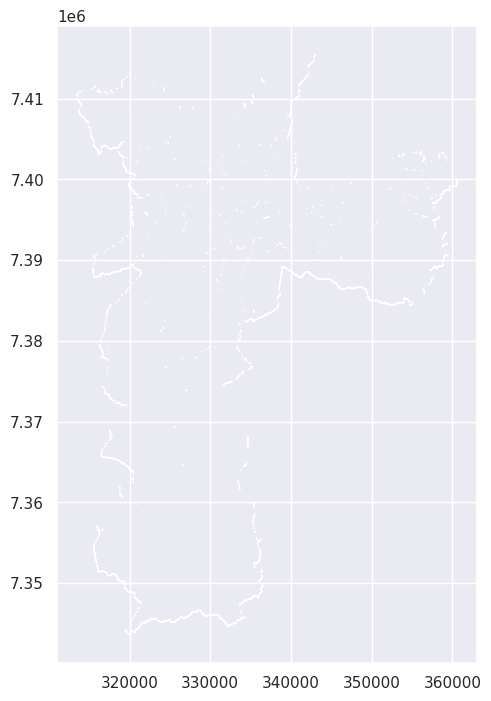

In [28]:
diferenca = distritos10.overlay(distritos22, how='difference')
diferenca.plot()

In [29]:
diferenca.geometry.area.max()

23211.461281901018

In [30]:
diferenca['area'] = diferenca.geometry.area
diferenca = diferenca.sort_values('area', ascending=False)
diferenca

,ID,CD_GEOCODD,NM_DISTRIT,geometry,area
31,4491,355030833,IGUATEMI,"MULTIPOLYGON (((355031.568 7384493.912, 355020...",2.321146e+04
52,4516,355030858,PEDREIRA,"MULTIPOLYGON (((332394.910 7378616.326, 332401...",1.436260e+04
23,4483,355030825,CIDADE TIRADENTES,"MULTIPOLYGON (((357437.586 7387598.403, 357421...",5.125604e+03
33,4494,355030836,ITAIM PAULISTA,"MULTIPOLYGON (((357381.135 7397635.182, 357381...",3.536199e+02
15,4475,355030817,CAMPO LIMPO,"MULTIPOLYGON (((320369.392 7387173.643, 320372...",2.665485e+02
...,...,...,...,...,...
45,4509,355030851,MANDAQUI,"MULTIPOLYGON (((334371.856 7402486.536, 334371...",1.639394e-10
14,4474,355030816,CAMPO GRANDE,"MULTIPOLYGON (((329548.687 7379052.610, 329548...",1.243139e-10
7,4467,355030809,BOM RETIRO,"MULTIPOLYGON (((333961.435 7396024.127, 333961...",2.901178e-11
76,4544,355030886,VILA GUILHERME,"POLYGON ((336941.354 7400522.245, 336941.354 7...",2.023414e-14


Dado que alguns distritos apresentaram diferenças, vamos definir uma tolerância (em metros quadrados) para avaliarmos visualmente.

In [31]:
tolerancia_distritos = 5**2

<Axes: >

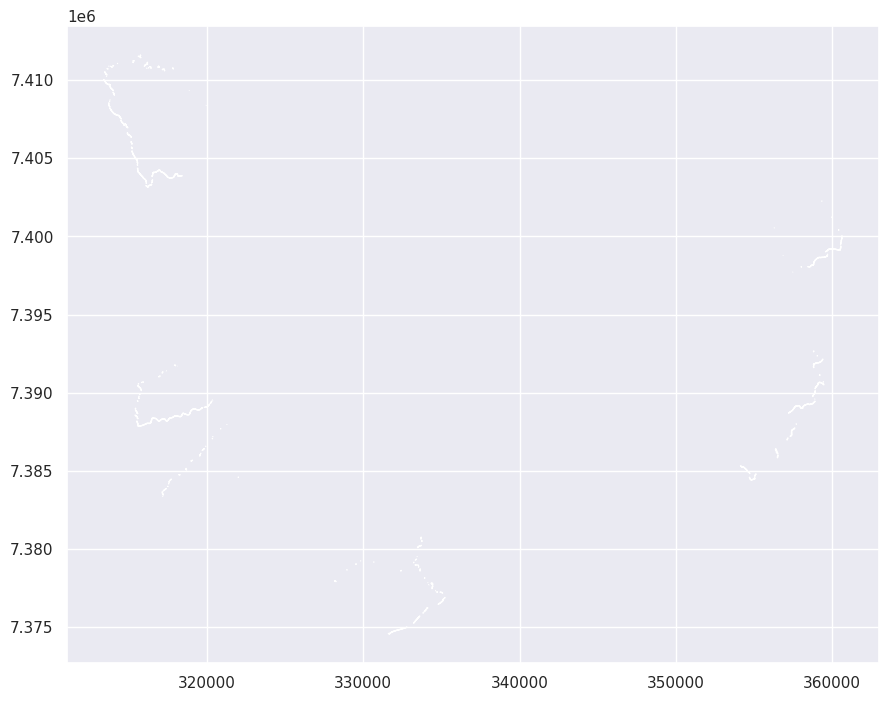

In [32]:
diferenca[diferenca.geometry.area > tolerancia_distritos].plot()

In [33]:
diferenca[diferenca.geometry.area > tolerancia_distritos].shape

(8, 5)

Apenas 8 distritos apresentaram diferenças maiores do que a tolerância atual. Vamos avaliá-los visualmente.

In [34]:
distritos_diferentes = diferenca.loc[diferenca.geometry.area > tolerancia_distritos, 'CD_GEOCODD'].tolist()
distritos_diferentes

['355030833',
 '355030858',
 '355030825',
 '355030836',
 '355030817',
 '355030865',
 '355030803',
 '355030822']

In [35]:
mapa_distritos = distritos10[distritos10['CD_GEOCODD'].isin(distritos_diferentes)].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_distritos = distritos22[distritos22['CD_DIST'].isin(distritos_diferentes)].explore(
    m=mapa_distritos,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_distritos = diferenca[diferenca['CD_GEOCODD'].isin(distritos_diferentes)].explore(
    m=mapa_distritos,
    name='Diferença',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(mapa_distritos)  # use folium to add layer control

mapa_distritos

A inspeção visual indica que os distritos se mantiveram os mesmos, com diferenças apenas quanto a ajustes pontuais nos desenhos dos polígonos de distritos de fronteira. Para confirmar, podemos avaliar a interseção entre os distritos para confirmação.

## Proporcionalidade das geometrias


Temos 2 formas de entender as relações entre as geometrias dos dois censos. Para exemplificar, vamos supor 1 geometria (A) do censo mais recente e 2 geometrias (B e C) do censo mais antigo, sendo que A está contido em B e C, mas B e C não estão contidos em A.

Uma forma é a composição da geometria A em relação às geometrias B e C, ou seja, quanto as interseções A∩B e A∩C representam de A. Essa composição é interessante para compreendermos o setor A e os valores inferidos para ele.

A outra forma é quanto a interção A∩B representa de B e quanto a interseção A∩C representa de C. Essa forma é a que precisamos para inferirmos os valores de A no censo mais antigo, já que para o censo mais antigo possuímos apenas os valores de B e C.

As próximas seções buscam calcular essas duas formas.

### 2022 em relação a 2022

In [142]:
def prop(
    row:GeoSeries,
    other:GeoSeries|GeoDataFrame,
    buffer:float=0,
    left_key_col:str=None,
    right_key_col:str=None,
    only_intersections:bool=True,
    method:str='intersection'
) -> GeoDataFrame:
    """
    Calcula as propriedades de interseção entre uma GeoSeries (representando uma geometria única) e uma GeoSeries (contendo uma série de geometrias) ou GeoDataFrame.

    Parâmetros:
    - row (GeoSeries): Uma GeoSeries representando a geometria para a qual as propriedades de interseção serão calculadas.
    - other (GeoSeries ou GeoDataFrame): Uma GeoSeries ou GeoDataFrame representando as geometrias com as quais 'row' será intersectada.
    - buffer (float, opcional): Distância de buffer aplicada à geometria de 'row' antes de calcular a interseção. O padrão é -16.
    - left_key_col (str, opcional): Nome da coluna em 'row' representando o valor da chave. O padrão é None.
    - right_key_col (str, opcional): Nome da coluna em 'other' representando o valor da chave. O padrão é None.
    - only_intersections (bool, opcional): Se True, retorna apenas geometrias com área de interseção não nula. O padrão é True.
    - method (str, opcional): Pode receber os valores de 'intersection' ou 'difference'. O padrão é 'intersection'.

    Retorna:
    - GeoDataFrame: Um GeoDataFrame contendo as propriedades de interseção, incluindo as geometrias intersectadas, área de interseção e
                    percentual da área de interseção em relação à geometria original de 'row'. Também pode incluir valores da chave de 'row' e 'other' se especificados.

    Observação:
    - Se 'other' for um GeoDataFrame, a função assume que ele contém dados de geometria na coluna 'geometry'.
    - Se 'other' for uma GeoSeries, ela será convertida em um GeoDataFrame com uma coluna 'geometry'.
    - O GeoDataFrame resultante conterá geometrias resultantes da interseção entre 'row' e 'other'.
    - A coluna 'inter_area' representa a área das geometrias de interseção.
    - A coluna 'inter_perc' representa o percentual da área de interseção em relação à área da geometria original de 'row'.
    - Se 'left_key_col' for fornecido, a coluna especificada de 'row' será incluída no GeoDataFrame resultante.
    - Se 'only_intersections' for True, o GeoDataFrame resultante conterá apenas geometrias intersectadas (onde 'inter_perc' > 0).
    - Se 'method' for 'intersection', a similaridade é calculada pela interseção entre a geometrias de row e other.
    - Se 'differnce', primeiro é calculada a diferença das geometrias de row e other e a similaridade é caculada como 1 - diferença.area/row.geometry.area.
    """
    geom = row['geometry']
    geom = geom.buffer(buffer)
    
    if isinstance(other, GeoDataFrame):
        cols = ['geometry']
        if right_key_col:
            if right_key_col in other.columns:
                cols.insert(0, right_key_col)
        gdf = other[cols].copy()
        
    if isinstance(other, GeoSeries):
        gdf = GeoDataFrame({'geometry': other.copy()})
        gdf.set_geometry('geometry')

    if method=='intersection':
        gdf['geometry'] = gdf.intersection(geom)
        gdf['inter_area'] = gdf['geometry'].area
        gdf['inter_perc'] = gdf['inter_area']/geom.area
    elif method=='difference':
        gdf['geometry'] = gdf['geometry'].apply(lambda x: geom.difference(x))
        gdf['inter_perc'] = 1- gdf['geometry'].area/geom.area
        
    if left_key_col:
        gdf.insert(0, left_key_col, row[left_key_col])
    if only_intersections:
        gdf = gdf[gdf['inter_perc'] > 0]
    return gdf

In [147]:

prop(distritos22.iloc[0], distritos10[['CD_GEOCODD', 'geometry']], left_key_col='CD_DIST', right_key_col='CD_GEOCODD').sort_values('inter_perc', ascending=False)

,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
830,355030801,355030801,"POLYGON ((338561.902 7394464.275, 338564.830 7...",7.133649e+06,9.999911e-01
922,355030801,355030893,"MULTIPOLYGON (((338734.574 7392064.455, 338742...",3.641472e+01,5.104596e-06
914,355030801,355030885,"MULTIPOLYGON (((339863.899 7394315.579, 339863...",1.591402e+01,2.230819e-06
909,355030801,355030880,"MULTIPOLYGON (((339863.899 7394315.579, 339857...",7.737985e+00,1.084707e-06
837,355030801,355030808,"MULTIPOLYGON (((338845.896 7394783.596, 338843...",1.509633e+00,2.116195e-07
901,355030801,355030872,"MULTIPOLYGON (((340738.300 7391308.855, 340785...",9.423723e-01,1.321013e-07
882,355030801,355030853,"MULTIPOLYGON (((338359.502 7394255.270, 338359...",7.343813e-01,1.029452e-07


In [146]:

prop(distritos22.iloc[0], distritos10[['CD_GEOCODD', 'geometry']], left_key_col='CD_DIST', right_key_col='CD_GEOCODD', method='difference').sort_values('inter_perc', ascending=False)

,CD_DIST,CD_GEOCODD,geometry,inter_perc
830,355030801,355030801,"MULTIPOLYGON (((339568.686 7391450.320, 339574...",9.999911e-01
922,355030801,355030893,"POLYGON ((339568.672 7391450.324, 339556.505 7...",5.104596e-06
914,355030801,355030885,"POLYGON ((339568.672 7391450.324, 339556.505 7...",2.230819e-06
909,355030801,355030880,"POLYGON ((339568.672 7391450.324, 339556.505 7...",1.084707e-06
837,355030801,355030808,"POLYGON ((339568.672 7391450.324, 339556.505 7...",2.116195e-07
...,...,...,...,...
860,355030801,355030831,"POLYGON ((339568.672 7391450.324, 339556.505 7...",6.661338e-16
859,355030801,355030830,"POLYGON ((339568.672 7391450.324, 339556.505 7...",6.661338e-16
858,355030801,355030829,"POLYGON ((339568.672 7391450.324, 339556.505 7...",6.661338e-16
857,355030801,355030828,"POLYGON ((339568.672 7391450.324, 339556.505 7...",6.661338e-16


In [38]:
prop_22 = distritos22.copy()
prop_22 = prop_22.apply(lambda x: prop(x, distritos10[['CD_GEOCODD', 'geometry']], left_key_col='CD_DIST', right_key_col='CD_GEOCODD'), axis=1)
prop_22 = pd.concat(prop_22.values)
prop_22

,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
830,355030801,355030801,"POLYGON ((338561.902 7394464.275, 338564.830 7...",7.133649e+06,9.999911e-01
837,355030801,355030808,"MULTIPOLYGON (((338845.896 7394783.596, 338843...",1.509633e+00,2.116195e-07
882,355030801,355030853,"MULTIPOLYGON (((338359.502 7394255.270, 338359...",7.343813e-01,1.029452e-07
901,355030801,355030872,"MULTIPOLYGON (((340738.300 7391308.855, 340785...",9.423723e-01,1.321013e-07
909,355030801,355030880,"MULTIPOLYGON (((339863.899 7394315.579, 339857...",7.737985e+00,1.084707e-06
...,...,...,...,...,...
866,355030896,355030837,"POLYGON ((353934.990 7397136.425, 353943.249 7...",9.582123e+00,1.076639e-06
876,355030896,355030847,"MULTIPOLYGON (((354202.561 7396540.774, 354211...",6.337849e-01,7.121156e-08
903,355030896,355030874,"MULTIPOLYGON (((353956.349 7397722.151, 353951...",1.939974e-02,2.179739e-09
913,355030896,355030884,"MULTIPOLYGON (((357381.135 7397635.181, 357380...",4.326556e+00,4.861283e-07


Por definção, a soma do percentual de todas as interseções de um dado distrito em 2022 devem ser 1.

In [39]:
soma_22 = prop_22[['CD_DIST','inter_perc']].groupby('CD_DIST').sum()
soma_22.value_counts()

inter_perc
0.994035      1
0.998680      1
1.000000      1
1.000000      1
1.000000      1
             ..
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
Name: count, Length: 96, dtype: int64


Apesar de alguns casos onde a interseção aparece com valores pouco menores do que 1, isso provavelmente se deve a erros de arredondamento no cálculo da área, já que não existe nenhuma interseção com valores próximos a 0.

Agora, vejamos se existe algum distrito de 2022 com interseção com mais de um distrito de 2010.

In [40]:
count_22 = prop_22[['CD_DIST','CD_GEOCODD']].groupby('CD_DIST').count()
count_22.value_counts()

CD_GEOCODD
6             25
4             20
5             20
7             15
3              7
8              6
9              2
2              1
Name: count, dtype: int64

Todos os setores de 2022 intersectam apenas um distrito de 2010, como esperado.

Por último, vamos inspecionar visualmente alguns distritos.

In [41]:
sample = prop_22.sample(5)
sample

,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
895,355030866,355030866,"POLYGON ((332542.638 7396286.512, 332555.099 7...",2.323447e+06,9.999735e-01
844,355030871,355030815,"MULTIPOLYGON (((329256.433 7384350.435, 329229...",1.901073e-01,1.192873e-08
907,355030814,355030878,"MULTIPOLYGON (((334103.753 7394251.822, 334103...",9.882839e+01,2.513305e-05
849,355030891,355030820,"MULTIPOLYGON (((341957.503 7396395.556, 341954...",2.348592e+01,2.639844e-06
831,355030888,355030802,"MULTIPOLYGON (((323613.991 7395530.095, 323609...",6.472354e-01,9.261359e-08


In [42]:
mapa_inter = distritos10[distritos10['CD_GEOCODD'].isin(sample['CD_GEOCODD'].unique())].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
    style_kwds={'fill': False},
)
mapa_inter = distritos22[distritos22['CD_DIST'].isin(sample['CD_DIST'].unique())].explore(
    m=mapa_inter,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
    style_kwds={'fill': False},
)
mapa_inter = sample.explore(
    m=mapa_inter,
    name='Interseções',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(mapa_inter)  # use folium to add layer control

mapa_inter

A análise visual indica que, de fato, os distritos não tiveram modificação.

### 2022 em relação a 2010

Invertendo a ordem dos dataframes na função para a comparação, temos o quanto as interseções representam em relação aos distritos de 2010. O esperado é que todos os valores sejam 1.0 novamente.

In [43]:
prop_10 = distritos10.copy()
prop_10 = prop_10.apply(lambda x: prop(x, distritos22[['CD_DIST', 'geometry']], left_key_col='CD_GEOCODD', right_key_col='CD_DIST'), axis=1)
prop_10 = pd.concat(prop_10.values)
prop_10

,CD_GEOCODD,CD_DIST,geometry,inter_area,inter_perc
831,355030801,355030801,"POLYGON ((339582.103 7391446.606, 339582.064 7...",7.133649e+06,9.999929e-01
838,355030801,355030808,"MULTIPOLYGON (((338561.801 7394464.163, 338558...",1.079318e+01,1.512985e-06
883,355030801,355030853,"MULTIPOLYGON (((338572.344 7392223.474, 338574...",7.409268e+00,1.038629e-06
902,355030801,355030872,"MULTIPOLYGON (((340822.866 7391329.199, 340830...",5.815371e+00,8.151970e-07
910,355030801,355030880,"MULTIPOLYGON (((338933.568 7394599.604, 338921...",1.746004e+00,2.447544e-07
...,...,...,...,...,...
867,355030896,355030837,"MULTIPOLYGON (((353969.877 7397061.711, 353983...",3.094854e-02,3.477360e-09
877,355030896,355030847,"MULTIPOLYGON (((354734.182 7396031.105, 354734...",1.554163e-01,1.746248e-08
904,355030896,355030874,"POLYGON ((353886.389 7397732.302, 353886.402 7...",5.317335e-02,5.974527e-09
914,355030896,355030884,"MULTIPOLYGON (((354805.847 7398051.652, 354783...",6.438261e-01,7.233992e-08


In [44]:
soma_10 = prop_10[['CD_GEOCODD','inter_perc']].groupby('CD_GEOCODD').sum()
soma_10.value_counts()

inter_perc
1.0           3
1.0           2
1.0           2
1.0           2
1.0           2
             ..
1.0           1
1.0           1
1.0           1
1.0           1
1.0           1
Name: count, Length: 89, dtype: int64

Novamente, alguns valores pouco menores do que 1.0, mas nenhum valor próximo a 0, o que indica erros de arredondamento.

In [45]:
count_10 = prop_10[['CD_DIST','CD_GEOCODD']].groupby('CD_DIST').count()
count_10.value_counts()

CD_GEOCODD
6             25
4             20
5             20
7             15
3              7
8              6
9              2
2              1
Name: count, dtype: int64

A contagem novamente indica que a relação entre os distritos é de um para um.

Finalmente, uma nova inspeção visual, mas dessa vez com a interseção baseada na geometria de 2010.

In [46]:
sample = prop_10.sample(5)
sample

,CD_GEOCODD,CD_DIST,geometry,inter_area,inter_perc
926,355030884,355030896,"MULTIPOLYGON (((356901.195 7397375.577, 356902...",4.326556,4.554640e-07
877,355030831,355030847,"MULTIPOLYGON (((354504.257 7393503.802, 354521...",0.992981,1.117123e-07
832,355030812,355030802,"MULTIPOLYGON (((324660.971 7393953.857, 324444...",884.249911,6.861166e-05
875,355030807,355030845,"POLYGON ((330837.440 7393448.871, 330855.990 7...",0.781458,2.830873e-07
858,355030818,355030828,"MULTIPOLYGON (((347149.861 7402108.031, 347151...",3.732899,2.713954e-07


In [47]:
mapa_inter_2 = distritos10[distritos10['CD_GEOCODD'].isin(sample['CD_GEOCODD'].unique())].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_inter_2 = distritos22[distritos22['CD_DIST'].isin(sample['CD_DIST'].unique())].explore(
    m=mapa_inter_2,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_inter_2 = sample.explore(
    m=mapa_inter_2,
    name='Interseções',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(mapa_inter_2)  # use folium to add layer control

mapa_inter_2


Tanto a análise de 2010 em relação a 2022, quanto a análise de 2022 em relação a 2010, indicam que os distritos se mantiveram iguais entre os censos, com poucos ajustes nas fronteiras do município, provavelmente devidos à melhor representação da geometria, mas sem alterações nas áreas mapeadas.

# Setores censitários

In [48]:
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES, filtro='CD_GEOCODM == "3550308"')
setores10.sample(3)

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
44041,109595.0,355030807000014,URBANO,35503080700,None,355030807,BELA VISTA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,44042,"POLYGON ((-46.64435 -23.55763, -46.64413 -23.5..."
57368,122848.0,355030870000026,URBANO,35503087000,None,355030870,SANTANA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,57369,"POLYGON ((-46.62473 -23.50338, -46.62453 -23.5..."
46097,111609.0,355030819000013,URBANO,35503081900,None,355030819,CAPÃO REDONDO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,46098,"POLYGON ((-46.77097 -23.66900, -46.77093 -23.6..."


In [49]:
setores22 = download_malha(Censo.CENSO_2022, Nivel.SETORES, filtro='CD_MUN == "3550308"')
setores22.sample(3)

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
68475,355030815000103P,0.002489,3,Sudeste,35,São Paulo,3550308,São Paulo,355030815,Campo Belo,...,3550308,São Paulo/SP,69,113,113,0,1.682927,19.512195,41,"POLYGON ((-46.66441 -23.62825, -46.66417 -23.6..."
73383,355030830000419P,0.024588,3,Sudeste,35,São Paulo,3550308,São Paulo,355030830,Grajaú,...,3550308,São Paulo/SP,530,207,207,0,2.944444,10.555556,180,"POLYGON ((-46.66920 -23.73951, -46.66923 -23.7..."
73180,355030830000026P,0.014336,3,Sudeste,35,São Paulo,3550308,São Paulo,355030830,Grajaú,...,3550308,São Paulo/SP,345,112,112,0,3.349515,11.650485,103,"POLYGON ((-46.67784 -23.75517, -46.67800 -23.7..."


## Proporcionalidade das geometrias

### Ajustando o CRS

In [50]:
setores10 = setores10.to_crs('EPSG:31983')
setores22 = setores22.to_crs('EPSG:31983')

### 2022 em relação a 2022

In [51]:
prop(setores22.iloc[0], setores10, left_key_col='CD_SETOR', right_key_col='CD_GEOCODI')

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000001P,355030801000001,"POLYGON ((339784.892 7392592.542, 339764.035 7...",70930.590833,0.988099
43405,355030801000001P,355030801000006,"MULTIPOLYGON (((339630.241 7392594.043, 339628...",373.279509,0.005200
43409,355030801000001P,355030801000010,"POLYGON ((339617.259 7392754.613, 339531.109 7...",9.240690,0.000129
43410,355030801000001P,355030801000011,"POLYGON ((339777.790 7392945.533, 339661.597 7...",471.770933,0.006572


In [65]:
%%time
props_22 = setores22.apply(lambda x: prop(x, setores10, left_key_col='CD_SETOR', right_key_col='CD_GEOCODI'), axis=1)
props_22 = pd.concat(props_22.values)
props_22

CPU times: user 17min 3s, sys: 445 ms, total: 17min 3s
Wall time: 17min 4s


,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000001P,355030801000001,"POLYGON ((339784.892 7392592.542, 339764.035 7...",70930.590833,9.880993e-01
43405,355030801000001P,355030801000006,"MULTIPOLYGON (((339630.241 7392594.043, 339628...",373.279509,5.199974e-03
43409,355030801000001P,355030801000010,"POLYGON ((339617.259 7392754.613, 339531.109 7...",9.240690,1.287275e-04
43410,355030801000001P,355030801000011,"POLYGON ((339777.790 7392945.533, 339661.597 7...",471.770933,6.572010e-03
43400,355030801000002P,355030801000001,"POLYGON ((339814.260 7392989.900, 339811.966 7...",18.451154,2.566574e-04
...,...,...,...,...,...
62241,355030896000338P,355030896000104,"POLYGON ((355756.807 7397691.040, 355771.483 7...",33668.997801,9.873096e-01
60168,355030896000339P,355030884000164,"POLYGON ((355953.783 7397535.061, 355931.532 7...",0.003980,3.971344e-07
61678,355030896000339P,355030896000044,"MULTIPOLYGON (((355952.348 7397493.652, 355945...",2.775304,2.769267e-04
62240,355030896000339P,355030896000103,"MULTIPOLYGON (((355573.427 7397636.444, 355567...",6952.030517,6.936909e-01


In [67]:
props_22.to_csv('setores2022_2022.parquet')

In [74]:
props_22.shape[0]/setores22.shape[0]

4.146165555233401

A análise geométrica indica uma média de aproximadamente 4,2 interseções por setor censitário de 2022, o que parece acima do razoável e provavelmente, contém uma série de falsos positivos.

Vamos avaliar em mais detalhes a base de dados resultante e depois avaliar visualmente alguns setores.

#### Resultados gerais

Além da média, vamos avaliar a distribuição de interseções por setor censitário de 2022.

In [86]:
counts_22 = props_22[['CD_SETOR', 'CD_GEOCODI']].groupby('CD_SETOR').count()

counts_22.describe()

,CD_GEOCODI
count,27592.000000
mean,4.146166
std,1.957557
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,55.000000


A distribuição possui média e mediana bem próximas, o que indica que tende a ser simétrica. Entretanto, possui outliers na cauda direita, indicado pela média pouco acima da mediana e grande diferença entre Q3 e máximo. Vamos remover os outliers e avaliar o histrograma da distribuição.

<Axes: ylabel='Count'>

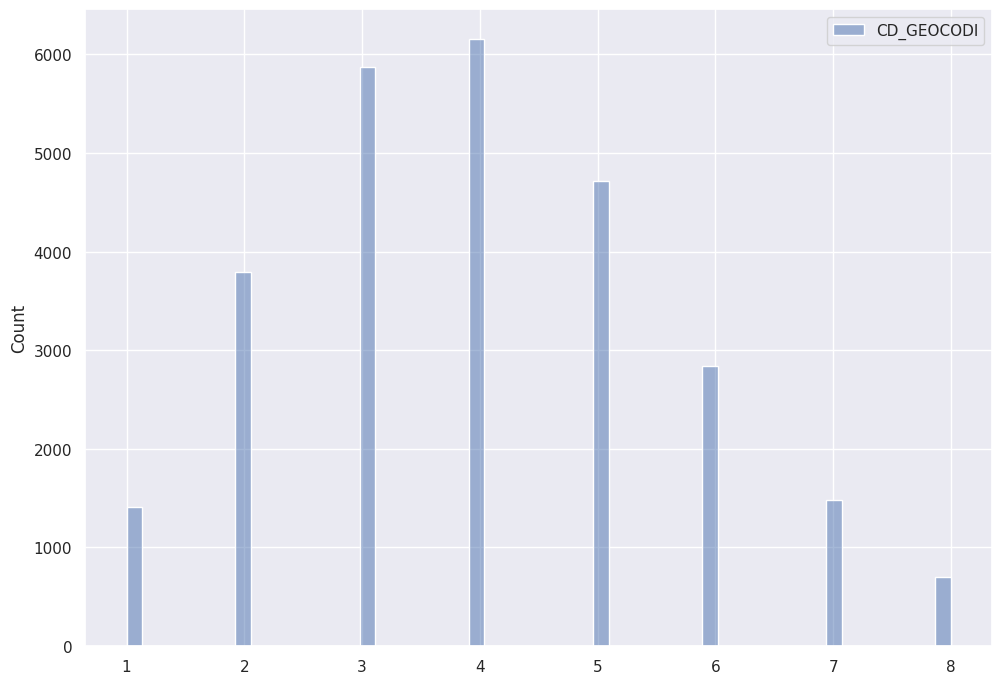

In [84]:
aiqs = counts_22['CD_GEOCODI'].quantile(0.75)-counts_22['CD_GEOCODI'].quantile(0.25)
limite_superiors = counts_22['CD_GEOCODI'].quantile(0.75)+1.5*aiqs

sns.histplot(counts_22.query(f'CD_GEOCODI <= {limite_superiors}'))

In [85]:
counts_22.query(f'CD_GEOCODI <= {limite_superiors}').describe()

,CD_GEOCODI
count,26963.000000
mean,3.997701
std,1.660038
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,8.000000


De fato, mesmo removendo os outliers, temos a maior parte do setores censitários possuindo 4 ou mais interseções, o que parece acima do esperado. Vamos avaliar os percentuais de interseção entre os setores.

In [87]:
props_22[['inter_perc']].describe()

,inter_perc
count,1.144010e+05
mean,2.411826e-01
std,4.008097e-01
min,1.286861e-25
25%,3.020854e-07
50%,6.843529e-04
75%,3.396242e-01
max,1.000000e+00


A média está bem acima da mediana, então esperamos uma distribuição assimétrica à direita, mas dessa vez por uma quantidade elevada de valores abaixo do esperado. Isso porque a distribuição desta vez é limitada à esquerda e à direita, de modo que dificilmente outliers nos limites distorçam a média.

Além disso, vemos que a maior parte da distribuição está bem abaixo de 1% (já que a mediana é igual a 0.0006843529), o que corrobora com a espectativa de interseções devidas a ajustes das geometrias, mas sem impacto real nas populações alvo desses setores.

Como esse intervalo é limitado nos dois lados, não precisamos remover os outliers para avaliar a distribuição.

<Axes: xlabel='inter_perc', ylabel='Probability'>

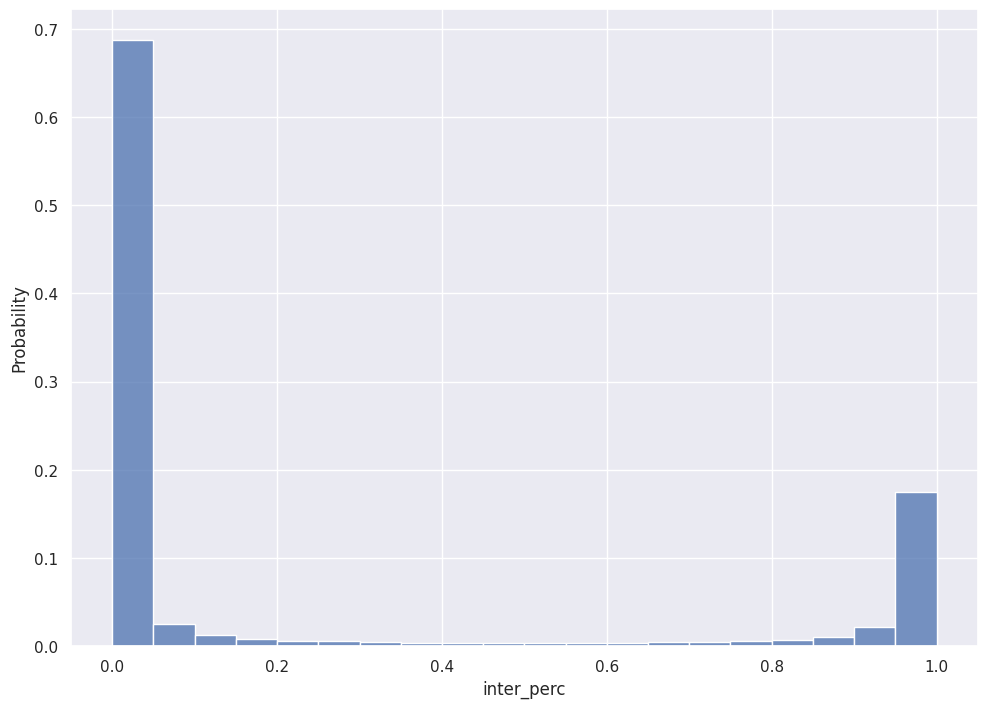

In [92]:
sns.histplot(props_22['inter_perc'], bins=20, stat='probability')

Conforme esperado, temos uma quandidade bastante elevada de interseções ($\approx$70%) com área menor do que 5% do setor censitário de 2022. 

#### Inspeção visual

In [101]:
sample_ids = props_22['CD_SETOR'].drop_duplicates().sample(100)
samples_10to22 = props_22[props_22['CD_SETOR'].isin(sample_ids)]
samples_10to22

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43653,355030803000092P,355030803000045,"MULTIPOLYGON (((318679.329 7404849.420, 318656...",2.621249e-02,2.396851e-07
43700,355030803000092P,355030803000092,"POLYGON ((318679.329 7404849.414, 318686.693 7...",1.093622e+05,9.999998e-01
43716,355030803000092P,355030803000108,"POLYGON ((318679.329 7404849.420, 318679.329 7...",3.208086e-11,2.933451e-16
50613,355030803000092P,355030842000139,"POLYGON ((318679.329 7404849.420, 318679.329 7...",1.220896e-09,1.116378e-14
43648,355030803000177P,355030803000040,"POLYGON ((315997.432 7406056.061, 315998.852 7...",1.025295e+04,9.813969e-01
...,...,...,...,...,...
62287,355030896000330P,355030896000150,"POLYGON ((353990.884 7397750.845, 353990.892 7...",3.800400e+04,9.884918e-01
62291,355030896000330P,355030896000154,"POLYGON ((354119.362 7397451.572, 354112.311 7...",2.691022e-03,6.999403e-08
62293,355030896000330P,355030896000156,"MULTIPOLYGON (((354223.858 7397663.354, 354223...",6.425886e-03,1.671386e-07
62294,355030896000330P,355030896000157,"POLYGON ((354188.592 7397615.827, 354220.125 7...",1.877753e+01,4.884075e-04


In [102]:
samples_10to22.geom_type.value_counts()

Polygon               311
MultiPolygon           66
GeometryCollection     21
Name: count, dtype: int64


Algumas interseções acabaram resultando em tipos de geometria mista (GeometryCollection), que pode conter pontos e linhas ao mesmo tempo que polígonos. Porém, esse tipo de geometria não pode ser exibido corretamente no follium. Ainda, como esse pontos e linhas não possuem área, podemos simplesmente removê-los dessas GeometryCollections.

In [124]:
def keep_only_polygons(geom:Geometry):
    if not isinstance(geom, GeometryCollection):
        return geom
        
    gl = []
    for g in geom.geoms:
        if isinstance(g, Polygon):
            gl.append(g)
            
    if len(gl)==0:
        return None

    return gl[0] if len(gl)==1 else MultiPolygon(gl)

In [125]:
geom_coll = samples_10to22.geom_type=='GeometryCollection'
samples_10to22[geom_coll]

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
44405,355030811000288P,355030811000064,GEOMETRYCOLLECTION (POLYGON ((328382.721 74030...,8.937415e-04,6.504108e-08
44406,355030811000288P,355030811000065,GEOMETRYCOLLECTION (POLYGON ((328377.201 74030...,3.100906e-01,2.256651e-05
42362,355030811000568P,355030811000193,GEOMETRYCOLLECTION (POLYGON ((326743.320 74058...,3.114222e+03,8.228968e-02
48186,355030827000339P,355030827000113,GEOMETRYCOLLECTION (POLYGON ((334901.515 73888...,2.200279e-08,5.341139e-12
49108,355030830000476P,355030830000484,GEOMETRYCOLLECTION (POLYGON ((332551.590 73683...,2.623808e-08,7.717828e-12
51393,355030839000119P,355030839000105,GEOMETRYCOLLECTION (POLYGON ((338299.079 74051...,9.741563e-03,1.112167e-07
51406,355030839000119P,355030839000118,GEOMETRYCOLLECTION (POLYGON ((338233.166 74050...,5.260400e+00,6.005652e-05
51408,355030839000119P,355030839000120,GEOMETRYCOLLECTION (POLYGON ((338769.808 74051...,2.126345e-01,2.427589e-06
51413,355030839000119P,355030839000125,GEOMETRYCOLLECTION (POLYGON ((338490.623 74052...,2.923754e-08,3.337968e-13
51331,355030839000127P,355030839000043,GEOMETRYCOLLECTION (POLYGON ((337841.419 74043...,3.084911e-03,1.162029e-07


In [127]:
samples_10to22.loc[geom_coll, 'geometry'] = samples_10to22.loc[geom_coll, 'geometry'].apply(keep_only_polygons)
samples_10to22[geom_coll]

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
44405,355030811000288P,355030811000064,"MULTIPOLYGON (((328382.721 7403015.983, 328382...",8.937415e-04,6.504108e-08
44406,355030811000288P,355030811000065,"POLYGON ((328377.201 7403033.750, 328317.665 7...",3.100906e-01,2.256651e-05
42362,355030811000568P,355030811000193,"POLYGON ((326743.320 7405889.875, 326743.126 7...",3.114222e+03,8.228968e-02
48186,355030827000339P,355030827000113,"POLYGON ((334901.515 7388843.623, 334901.515 7...",2.200279e-08,5.341139e-12
49108,355030830000476P,355030830000484,"MULTIPOLYGON (((332551.590 7368346.073, 332561...",2.623808e-08,7.717828e-12
51393,355030839000119P,355030839000105,"MULTIPOLYGON (((338299.079 7405127.971, 338313...",9.741563e-03,1.112167e-07
51406,355030839000119P,355030839000118,"MULTIPOLYGON (((338233.166 7405082.614, 338246...",5.260400e+00,6.005652e-05
51408,355030839000119P,355030839000120,"MULTIPOLYGON (((338769.808 7405163.709, 338765...",2.126345e-01,2.427589e-06
51413,355030839000119P,355030839000125,"MULTIPOLYGON (((338490.623 7405270.285, 338478...",2.923754e-08,3.337968e-13
51331,355030839000127P,355030839000043,"MULTIPOLYGON (((337841.419 7404324.651, 337856...",3.084911e-03,1.162029e-07


In [128]:
samples_10to22.geom_type.value_counts()

Polygon         318
MultiPolygon     80
Name: count, dtype: int64

In [149]:
mapa_inter_setor = setores10[setores10['CD_GEOCODI'].isin(samples_10to22['CD_GEOCODI'].unique())].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
    # style_kwds={'fill': False},
)
mapa_inter_setor = setores22[setores22['CD_SETOR'].isin(samples_10to22['CD_SETOR'].unique())].explore(
    m=mapa_inter_setor,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
    # style_kwds={'fill': False},
)
mapa_inter_setor = samples_10to22.query("inter_perc > 0.01").explore(
    m=mapa_inter_setor,
    name='Interseções com similaridade > 1%',  # name of the layer in the map
    color='purple',
)
mapa_inter_setor = samples_10to22.query("inter_perc <= 0.01").explore(
    m=mapa_inter_setor,
    name='Interseções com similaridade <= 1%',  # name of the layer in the map
    color='limegreen',
)

folium.LayerControl().add_to(mapa_inter_setor)  # use folium to add layer control

mapa_inter_setor